In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

tickers = ['SPY', 'QQQ', 'MSFT', 'AAPL', 'AMZN']

end_date = datetime.now()
start_date = end_date - timedelta(days=7) 

try:
    a_data = yf.download(
        tickers=tickers,
        start=start_date.strftime('%Y-%m-%d'),
        end=end_date.strftime('%Y-%m-%d'),
        interval="1m"
    )
    
    if a_data.empty:
        print("Error")
        exit() 
        
    print(a_data.head())

    # data to long
    df = a_data.stack(level=1).reset_index()

    df.rename(columns={
        'level_0': 'Datetime',
        'level_1': 'Ticker',  
        'Adj Close': 'Adj_Close' 
    }, inplace=True)
    
    df['Datetime'] = pd.to_datetime(df['Datetime'])

    df.sort_values(by=['Datetime', 'Ticker'], inplace=True)

    print("Long data")
    print(df.head(10)) 


except Exception as e:
    print('Error')

/var/folders/5_/t6j4c_393llc2ffbkjsdr9mr0000gn/T/ipykernel_47717/3456497280.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  a_data = yf.download(
[*********************100%***********************]  5 of 5 completed

Price                           Close                                      \
Ticker                           AAPL        AMZN        MSFT         QQQ   
Datetime                                                                    
2025-07-17 13:30:00+00:00  210.800003  223.591202  506.880005  558.119995   
2025-07-17 13:31:00+00:00  210.625000  223.649994  507.690002  558.090027   
2025-07-17 13:32:00+00:00  210.729996  223.266098  507.179993  557.590027   
2025-07-17 13:33:00+00:00  210.289993  223.345001  506.829987  557.390015   
2025-07-17 13:34:00+00:00  210.529999  223.399994  506.700012  557.655029   

Price                                        High                          \
Ticker                            SPY        AAPL        AMZN        MSFT   
Datetime                                                                    
2025-07-17 13:30:00+00:00  624.440002  210.910004  223.940002  507.459991   
2025-07-17 13:31:00+00:00  624.719971  210.850006  223.820007  507.690002  


/var/folders/5_/t6j4c_393llc2ffbkjsdr9mr0000gn/T/ipykernel_47717/3456497280.py:25: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = a_data.stack(level=1).reset_index()


In [2]:
import pandas as pd
import numpy as np

df.sort_values(by=['Datetime', 'Ticker'], inplace=True)

# VOL IMB
df['Close_prev'] = df.groupby('Ticker')['Close'].shift(1)
df['Volume_Imbalance'] = np.where(
    df['Close'] > df['Close_prev'],
    df['Volume'],
    np.where(
        df['Close'] < df['Close_prev'],
        -df['Volume'],
        0
    )
)
df['Volume_Imbalance'] = df['Volume_Imbalance'].fillna(0) 

df_wide = df.pivot_table(
    index='Datetime',
    columns='Ticker',
    values=['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Imbalance']
)

if ('Close', 'SPY') in df_wide.columns:
    df_wide[('Close', 'SPY')] = df_wide[('Close', 'SPY')].ffill()
    for col_name in ['Open', 'High', 'Low', 'Volume', 'Volume_Imbalance']: 
        if (col_name, 'SPY') in df_wide.columns:
            df_wide[(col_name, 'SPY')] = df_wide[(col_name, 'SPY')].ffill()

actual_tickers = df['Ticker'].unique()

# LOG RETURN
for ticker_symbol in actual_tickers:
    if ('Close', ticker_symbol) in df_wide.columns:
        df_wide[('Log_Return', ticker_symbol)] = np.log(df_wide['Close'][ticker_symbol] / df_wide['Close'][ticker_symbol].shift(1))
        df_wide[('Log_Return', ticker_symbol)] = df_wide[('Log_Return', ticker_symbol)].fillna(0.0)
    else:
        df_wide[('Log_Return', ticker_symbol)] = np.nan 

#  Corr_SPY
correlation_window = 5

for ticker_symbol in actual_tickers:
    if ticker_symbol == 'SPY':
        df_wide[('Corr_SPY', ticker_symbol)] = 1.0 
    else:
        if ('Log_Return', 'SPY') in df_wide.columns and ('Log_Return', ticker_symbol) in df_wide.columns:
            df_wide[('Corr_SPY', ticker_symbol)] = df_wide['Log_Return']['SPY'].rolling(
                window=correlation_window, min_periods=max(2, correlation_window // 2) 
            ).corr(df_wide['Log_Return'][ticker_symbol])
        else:
            df_wide[('Corr_SPY', ticker_symbol)] = np.nan


for col in df_wide.columns:
    if isinstance(col, tuple) and col[0] == 'Corr_SPY':
        df_wide[col] = df_wide[col].fillna(0.0)

new_columns = []
for col_tuple in df_wide.columns:
    if len(col_tuple) == 2:
        new_columns.append(f"{col_tuple[0]}_{col_tuple[1]}")
    elif len(col_tuple) == 1: 
        new_columns.append(col_tuple[0])
    else: 
        new_columns.append("_".join(col_tuple))
df_wide.columns = new_columns


df_long_final = pd.DataFrame()

for ticker_symbol in actual_tickers:
    base_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Volume_Imbalance', 'Log_Return']
    cols_to_extract = [f"{col_name}_{ticker_symbol}" for col_name in base_cols]

    corr_col_name_in_df_wide = f'Corr_SPY_{ticker_symbol}'
    if corr_col_name_in_df_wide in df_wide.columns:
        cols_to_extract.append(corr_col_name_in_df_wide)

    existing_cols = [col for col in cols_to_extract if col in df_wide.columns]

    if not existing_cols:
        continue 

    temp_df = df_wide[existing_cols].copy()

    new_temp_df_cols = []
    for col in temp_df.columns:
        if col.startswith('Corr_SPY_'):
            new_temp_df_cols.append('Corr_SPY')
        elif col.endswith(f'_{ticker_symbol}'):
            new_temp_df_cols.append(col.replace(f'_{ticker_symbol}', ''))
        else:
            new_temp_df_cols.append(col)
    temp_df.columns = new_temp_df_cols

    temp_df['Ticker'] = ticker_symbol
    temp_df.reset_index(inplace=True) 
    df_long_final = pd.concat([df_long_final, temp_df], ignore_index=True)

df_long_final.sort_values(by=['Datetime', 'Ticker'], inplace=True)
df_long_final.columns = [col.lower() for col in df_long_final.columns]

print('\n--- df_long_final.head() (final) ---')
print(df_long_final.head(20))

print('\n--- df_long_final.info() ---')
print(df_long_final.info())


--- df_long_final.head() (final) ---
                      datetime        open        high         low  \
0    2025-07-17 13:30:00+00:00  210.625000  210.910004  210.449997   
1950 2025-07-17 13:30:00+00:00  223.320007  223.940002  223.190002   
3900 2025-07-17 13:30:00+00:00  505.679993  507.459991  505.619995   
5850 2025-07-17 13:30:00+00:00  557.984985  558.424988  557.859985   
7800 2025-07-17 13:30:00+00:00  624.400024  624.700012  624.179993   
1    2025-07-17 13:31:00+00:00  210.809998  210.850006  210.460007   
1951 2025-07-17 13:31:00+00:00  223.654999  223.820007  223.520004   
3901 2025-07-17 13:31:00+00:00  506.875000  507.690002  506.394989   
5851 2025-07-17 13:31:00+00:00  558.169983  558.294983  557.784973   
7801 2025-07-17 13:31:00+00:00  624.440002  624.880005  624.429993   
2    2025-07-17 13:32:00+00:00  210.610001  210.919998  210.345001   
1952 2025-07-17 13:32:00+00:00  223.669998  223.889999  223.244995   
3902 2025-07-17 13:32:00+00:00  507.829987  508.2999

In [27]:
import backtrader as bt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec


class CustomPandasData(bt.feeds.PandasData):
    lines = ('volume_imbalance', 'log_return', 'corr_spy',)
    params = (
        ('volume_imbalance', -1),
        ('log_return', -1),
        ('corr_spy', -1),
    )

# Ваш класс LongShortStrategy остается без изменений (он уже содержит логику `exit_on_reverse_signal`)
class LongShortStrategy(bt.Strategy):
    params = (
        ('period', 20), # SMA period
        ('buy_threshold_volume_imbalance', 100000), # Threshold for strong positive VI (now implies SHORT)
        ('sell_threshold_volume_imbalance', -100000), # Threshold for strong negative VI (now implies LONG)
        ('correlation_threshold_buy', 0.5), # Correlation for LONG entries (when VI is negative)
        ('correlation_threshold_sell', -0.5), # Correlation for SHORT entries (when VI is positive)
        ('stake', 10), # Number of shares/units to trade
        ('printlog', True),
        ('atr_period', 14),
        ('atr_multiplier', 2.0), # For potential future ATR-based stops
        ('exit_on_reverse_signal', True), # Still true for active reversal
    )

    def log(self, txt, dt=None, tradeid='', **kwargs):
        """Logs strategy messages."""
        if self.p.printlog:
            dt = dt or self.datas[0].datetime.datetime(0)
            trade_info = f" [Trade {tradeid}]" if tradeid else ""
            print(f'{dt.isoformat()}{trade_info}, {txt}')

    def __init__(self):
        """Initializes indicators and tracking variables."""
        self.inds = {}
        for d in self.datas:
            self.inds[d] = {
                'vi': d.lines.volume_imbalance,
                'corr': d.lines.corr_spy,
                'atr': bt.indicators.ATR(d, period=self.p.atr_period),
                'sma': bt.indicators.SMA(d.close, period=self.p.period)
            }
        
        self.trade_history = []
        self.current_positions = {}
        self.trade_counter = 0 
        self.portfolio_values = []
        self.dates = []
        self.orders = {} 

    def notify_order(self, order):
        """Processes order notifications."""
        ticker = order.data._name

        if order.status in [order.Submitted, order.Accepted]:
            self.orders[ticker] = order
            return

        if order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log(f'Order for {ticker} was {order.getstatusname()}', tradeid=order.ref)
            if ticker in self.orders and self.orders[ticker] == order:
                del self.orders[ticker]
            return
        
        if order.status == order.Completed:
            self.log(f'Order Completed for {ticker}: Price={order.executed.price:.2f}, Size={order.executed.size}, Comm={order.executed.comm:.2f}', tradeid=order.ref)
            
            if ticker in self.orders and self.orders[ticker] == order:
                del self.orders[ticker]

            current_position_size = self.getposition(order.data).size

            if order.isbuy(): # This means we are opening a LONG or closing a SHORT
                if current_position_size > 0 and ticker not in self.current_positions:
                    # New LONG position opened
                    self.trade_counter += 1
                    trade_id = self.trade_counter
                    self.current_positions[ticker] = {
                        'tradeid': trade_id,
                        'type': 'LONG',
                        'entry_price': order.executed.price,
                        'size': order.executed.size,
                        'entry_time': self.datas[0].datetime.datetime(0),
                        'entry_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': self.inds[order.data]['corr'][0],
                    }
                    self.log(
                        f"{ticker} LONG OPENED - Price: {order.executed.price:.2f}, Size: {order.executed.size}",
                        tradeid=trade_id
                    )
                elif current_position_size == 0 and ticker in self.current_positions and self.current_positions[ticker]['type'] == 'SHORT':
                    # Closing a SHORT position
                    position = self.current_positions.pop(ticker)
                    pnl = (position['entry_price'] - order.executed.price) * abs(position['size'])
                    pnl -= order.executed.comm 
                    
                    self.trade_history.append({
                        'tradeid': position['tradeid'],
                        'ticker': ticker,
                        'type': 'SHORT',
                        'entry_price': position['entry_price'],
                        'exit_price': order.executed.price,
                        'size': position['size'],
                        'entry_time': position['entry_time'],
                        'exit_time': self.datas[0].datetime.datetime(0),
                        'pnl': pnl,
                        'entry_vi': position['entry_vi'],
                        'exit_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': position['entry_corr'],
                        'exit_corr': self.inds[order.data]['corr'][0]
                    })
                    self.log(
                        f"{ticker} SHORT CLOSED - PnL: {pnl:.2f}",
                        tradeid=position['tradeid']
                    )

            elif order.issell(): # This means we are opening a SHORT or closing a LONG
                if current_position_size < 0 and ticker not in self.current_positions:
                    # New SHORT position opened
                    self.trade_counter += 1
                    trade_id = self.trade_counter
                    self.current_positions[ticker] = {
                        'tradeid': trade_id,
                        'type': 'SHORT',
                        'entry_price': order.executed.price,
                        'size': order.executed.size, # This will be negative
                        'entry_time': self.datas[0].datetime.datetime(0),
                        'entry_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': self.inds[order.data]['corr'][0],
                    }
                    self.log(
                        f"{ticker} SHORT OPENED - Price: {order.executed.price:.2f}, Size: {order.executed.size}",
                        tradeid=trade_id
                    )
                elif current_position_size == 0 and ticker in self.current_positions and self.current_positions[ticker]['type'] == 'LONG':
                    # Closing a LONG position
                    position = self.current_positions.pop(ticker)
                    pnl = (order.executed.price - position['entry_price']) * position['size']
                    pnl -= order.executed.comm 
                    
                    self.trade_history.append({
                        'tradeid': position['tradeid'],
                        'ticker': ticker,
                        'type': 'LONG',
                        'entry_price': position['entry_price'],
                        'exit_price': order.executed.price,
                        'size': position['size'],
                        'entry_time': position['entry_time'],
                        'exit_time': self.datas[0].datetime.datetime(0),
                        'pnl': pnl,
                        'entry_vi': position['entry_vi'],
                        'exit_vi': self.inds[order.data]['vi'][0],
                        'entry_corr': position['entry_corr'],
                        'exit_corr': self.inds[order.data]['corr'][0]
                    })
                    self.log(
                        f"{ticker} LONG CLOSED - PnL: {pnl:.2f}",
                        tradeid=position['tradeid']
                    )

    def next(self):
        """Strategy algorithm running on every bar."""
        current_date = self.datas[0].datetime.datetime(0)
        self.dates.append(current_date)
        self.portfolio_values.append(self.broker.getvalue())

        for data in self.datas:
            ticker = data._name
            
            if ticker == 'SPY' or len(data) < max(self.p.period, self.p.atr_period, 2):
                continue

            if ticker in self.orders and self.orders[ticker].status in [self.orders[ticker].Submitted, self.orders[ticker].Accepted]:
                continue
            
            vi = self.inds[data]['vi'][0]
            corr = self.inds[data]['corr'][0]
            sma = self.inds[data]['sma'][0]

            if any(np.isnan(x) for x in [vi, corr, sma]):
                continue

            position = self.getposition(data)
            has_long_position = position.size > 0
            has_short_position = position.size < 0

            # --- UPDATED LOGIC FOR LONG/SHORT CONDITIONS ---
            # LONG condition: Strong negative VI (sellers dominated, expect reversal UP)
            # AND low/negative correlation (for contrarian play) AND price below SMA
            long_condition = (
                vi < self.p.sell_threshold_volume_imbalance and # Now using sell_threshold for LONG entry
                corr < self.p.correlation_threshold_sell and    # Negative correlation (for buying cheap against market)
                data.close[0] < sma                             # Price below SMA (further confirmation of oversold/reversal potential)
            )

            # SHORT condition: Strong positive VI (buyers dominated, expect reversal DOWN)
            # AND high positive correlation (for selling expensive with market downturn) AND price above SMA
            short_condition = (
                vi > self.p.buy_threshold_volume_imbalance and  # Now using buy_threshold for SHORT entry
                corr > self.p.correlation_threshold_buy and     # Positive correlation (for selling expensive with market)
                data.close[0] > sma                             # Price above SMA (further confirmation of overbought/reversal potential)
            )
            # --- END OF UPDATED LOGIC ---

            # Logic to open new positions
            if not has_long_position and not has_short_position:
                if long_condition:
                    self.buy(data=data, size=self.p.stake) 
                elif short_condition:
                    self.sell(data=data, size=self.p.stake)
            
            # Logic to manage open positions (close or reverse)
            else:
                if has_long_position:
                    # Close long if its condition is no longer met OR a strong reverse short signal appears
                    if not long_condition or (self.p.exit_on_reverse_signal and short_condition):
                        self.log(f'Attempting to close LONG position for {ticker} by signal change/reverse.', tradeid=self.current_positions.get(ticker, {}).get('tradeid'))
                        self.close(data=data)
                        if self.p.exit_on_reverse_signal and short_condition:
                            self.sell(data=data, size=self.p.stake)
                            self.log(f'Reversed from LONG to SHORT for {ticker}.', tradeid=self.current_positions.get(ticker, {}).get('tradeid'))
                
                elif has_short_position:
                    # Close short if its condition is no longer met OR a strong reverse long signal appears
                    if not short_condition or (self.p.exit_on_reverse_signal and long_condition):
                        self.log(f'Attempting to close SHORT position for {ticker} by signal change/reverse.', tradeid=self.current_positions.get(ticker, {}).get('tradeid'))
                        self.close(data=data)
                        if self.p.exit_on_reverse_signal and long_condition:
                            self.buy(data=data, size=self.p.stake)
                            self.log(f'Reversed from SHORT to LONG for {ticker}.', tradeid=self.current_positions.get(ticker, {}).get('tradeid'))

""" 
    
    def stop(self):

        Actions to perform after the strategy finishes
        self.log("=== STRATEGY FINISHED ===")

        for ticker, position_info in list(self.current_positions.items()): 
            data = None
            for d in self.datas:
                if d._name == ticker:
                    data = d
                    break
            
            if data and self.getposition(data).size != 0:
                self.log(f"Forcing close of {position_info['type']} position for {ticker} at end of backtest.", tradeid=position_info['tradeid'])
                self.close(data=data)
            else: 
                 del self.current_positions[ticker] 

        self.log(f"Total Trades recorded in history: {len(self.trade_history)}")
        
        if self.current_positions:
            self.log(f"WARNING: Still {len(self.current_positions)} open positions after forced closure.")
            for ticker, info in self.current_positions.items():
                self.log(f"  - {ticker}: {info['type']} size {info['size']} opened at {info['entry_time']}", tradeid=info['tradeid'])

        self.plot_results()
        self.save_trades()
 
    def plot_results(self):
        Generates and saves performance plots.
        try:
            plt.style.use('seaborn-v0_8')
            fig = plt.figure(figsize=(15, 10))
            gs = GridSpec(3, 1, figure=fig, height_ratios=[3, 1, 1])
            
            ax1 = fig.add_subplot(gs[0, :])
            ax1.plot(self.dates, self.portfolio_values, 
                    label='Portfolio Value', linewidth=2, color='navy')
            
            if self.trade_history:
                trades_df = pd.DataFrame(self.trade_history)
                trades_df['entry_time'] = pd.to_datetime(trades_df['entry_time'])
                trades_df['exit_time'] = pd.to_datetime(trades_df['exit_time'])
                legend_handles = {}

                for idx, trade in trades_df.iterrows():
                    color = 'green' if trade['type'] == 'LONG' else 'red'

                    entry_label = f"{trade['type']} Entry"
                    if entry_label not in legend_handles:
                        sc = ax1.scatter(trade['entry_time'], 
                                        self.get_portfolio_value_at(trade['entry_time']), 
                                        color=color, marker='^', s=100, zorder=5)
                        legend_handles[entry_label] = sc
                    else:
                        ax1.scatter(trade['entry_time'], 
                                    self.get_portfolio_value_at(trade['entry_time']), 
                                    color=color, marker='^', s=100, zorder=5)


                    exit_label = f"{trade['type']} Exit"
                    if exit_label not in legend_handles:
                        sc = ax1.scatter(trade['exit_time'], 
                                        self.get_portfolio_value_at(trade['exit_time']), 
                                        color=color, marker='o', s=80, zorder=5)
                        legend_handles[exit_label] = sc
                    else:
                        ax1.scatter(trade['exit_time'], 
                                    self.get_portfolio_value_at(trade['exit_time']), 
                                    color=color, marker='o', s=80, zorder=5)
            
            ax1.set_title('Portfolio Performance with Trades', fontsize=14, pad=10)
            ax1.set_ylabel('Value ($)', fontsize=10)
            ax1.legend(handles=list(legend_handles.values()), labels=list(legend_handles.keys()), loc='upper left')
            ax1.grid(True, linestyle=':', alpha=0.7)
            ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
            fig.autofmt_xdate() 

            ax2 = fig.add_subplot(gs[1, :], sharex=ax1) 
            if self.trade_history:
                trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
                ax2.plot(trades_df['exit_time'], trades_df['cum_pnl'], 
                        color='purple', linewidth=1.5)
                ax2.fill_between(trades_df['exit_time'], trades_df['cum_pnl'], 
                                where=trades_df['cum_pnl']>=0, 
                                facecolor='green', alpha=0.2)
                ax2.fill_between(trades_df['exit_time'], trades_df['cum_pnl'], 
                                where=trades_df['cum_pnl']<=0, 
                                facecolor='red', alpha=0.2)
                ax2.axhline(0, color='black', linestyle='--', linewidth=0.8)
                ax2.set_title('Cumulative Profit & Loss', fontsize=12, pad=8)
                ax2.set_ylabel('PnL ($)', fontsize=10)
                ax2.grid(True, linestyle=':', alpha=0.5)
            else:
                ax2.text(0.5, 0.5, 'No trades to plot.', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, fontsize=12)

            ax3 = fig.add_subplot(gs[2, :])
            if self.trade_history:
                trades_df['hour'] = trades_df['entry_time'].dt.hour
                hour_dist = trades_df.groupby('hour').agg({
                    'tradeid': 'count',
                    'pnl': 'mean'
                }).reset_index()
            
                all_hours = pd.DataFrame({'hour': range(24)})
                hour_dist = pd.merge(all_hours, hour_dist, on='hour', how='left').fillna({'tradeid': 0, 'pnl': 0})

                colors = ['green' if pnl > 0 else 'red' for pnl in hour_dist['pnl']]
                ax3.bar(hour_dist['hour'], hour_dist['tradeid'], color=colors, alpha=0.7)
                
                ax3.set_title('Trade Activity by Hour (Green = Avg Profit, Red = Avg Loss)', 
                             fontsize=12, pad=8)
                ax3.set_xlabel('Hour of Day', fontsize=10)
                ax3.set_ylabel('Number of Trades', fontsize=10)
                ax3.set_xticks(range(24))
                ax3.grid(True, axis='y', linestyle=':', alpha=0.5)
            else:
                ax3.text(0.5, 0.5, 'No trades to plot.', horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, fontsize=12)
            
            plt.tight_layout()
            plt.savefig('trading_performance.png', dpi=300, bbox_inches='tight')
            plt.close()
            print("\nPerformance chart saved to 'trading_performance.png'")
            
        except Exception as e:
            print(f"\nError in plotting: {str(e)}")

    def get_portfolio_value_at(self, dt):
        
        if not self.dates:
            return self.broker.startingcash

        idx = (np.abs(np.array(self.dates) - dt)).argmin()
        return self.portfolio_values[idx]

    def save_trades(self):
        if self.trade_history:
            trades_df = pd.DataFrame(self.trade_history)
            trades_df.to_csv('trades_history.csv', index=False)
            print("Trades history saved to 'trades_history.csv'")
            
            # Performance metrics
            if len(self.portfolio_values) > 1:
                initial = self.portfolio_values[0]
                final = self.portfolio_values[-1]
                returns = (final - initial) / initial * 100
            else:
                initial = self.broker.startingcash
                final = self.broker.getvalue()
                returns = ((final - initial) / initial * 100) if initial != 0 else 0


            print("\n=== Performance Summary ===")
            print(f"Initial Capital: ${initial:,.2f}")
            print(f"Final Capital:   ${final:,.2f}")
            print(f"Total Return:    {returns:.2f}%")
            
            wins = trades_df[trades_df['pnl'] > 0]
            losses = trades_df[trades_df['pnl'] <= 0]
            
            print(f"\nTotal Trades:    {len(trades_df)}")
            if len(trades_df) > 0:
                print(f"Win Rate:        {len(wins)/len(trades_df):.1%}")
                print(f"Avg Win Trade:   ${wins['pnl'].mean():.2f}")
                print(f"Avg Loss Trade:  ${losses['pnl'].mean():.2f}")
                if losses['pnl'].sum() != 0:
                    print(f"Profit Factor:   {wins['pnl'].sum()/abs(losses['pnl'].sum()):.2f}")
                else:
                    print("Profit Factor:   N/A (No losses)")
            else:
                print("No trades to calculate detailed metrics.")

            # Max Drawdown from portfolio_values (more accurate)
            if self.portfolio_values:
                print(f"Max Drawdown:    {self.calculate_max_drawdown():.2f}%")
            else:
                print("Max Drawdown:    N/A (No portfolio values recorded)")


    def calculate_max_drawdown(self):
       
        if not self.portfolio_values:
            return 0.0
        
        peak = self.portfolio_values[0]
        max_dd = 0.0
        for value in self.portfolio_values:
            if value > peak:
                peak = value
            dd = (peak - value) / peak * 100
            if dd > max_dd:
                max_dd = dd
        return max_dd
"""

' \n\n    def stop(self):\n\n        Actions to perform after the strategy finishes\n        self.log("=== STRATEGY FINISHED ===")\n\n        for ticker, position_info in list(self.current_positions.items()): \n            data = None\n            for d in self.datas:\n                if d._name == ticker:\n                    data = d\n                    break\n\n            if data and self.getposition(data).size != 0:\n                self.log(f"Forcing close of {position_info[\'type\']} position for {ticker} at end of backtest.", tradeid=position_info[\'tradeid\'])\n                self.close(data=data)\n            else: \n                 del self.current_positions[ticker] \n\n        self.log(f"Total Trades recorded in history: {len(self.trade_history)}")\n\n        if self.current_positions:\n            self.log(f"WARNING: Still {len(self.current_positions)} open positions after forced closure.")\n            for ticker, info in self.current_positions.items():\n              

Launching Monte Carlo (30 iterations)...


Monte Carlo Optimization:   0%|          | 0/30 [00:00<?, ?it/s]


--- Results ---

Top 5 combination by Sharpe Ratio:
     final_value  period  buy_threshold_volume_imbalance  sell_threshold_volume_imbalance  correlation_threshold_buy  correlation_threshold_sell  stake  total_return  sharpe_ratio  max_drawdown  num_trades
3   99681.842448      30                          175000                          -150000                        0.8                        -0.5      5     -0.318158           0.0      0.318158          73
13  99632.680991      35                          175000                          -175000                        0.6                        -0.4      5     -0.367319           0.0      0.367319          94
28  99610.115567      35                          200000                           -75000                        0.4                        -0.3      5     -0.389884           0.0      0.389884         111
5   99538.041733      20                          150000                          -100000                        0.7       

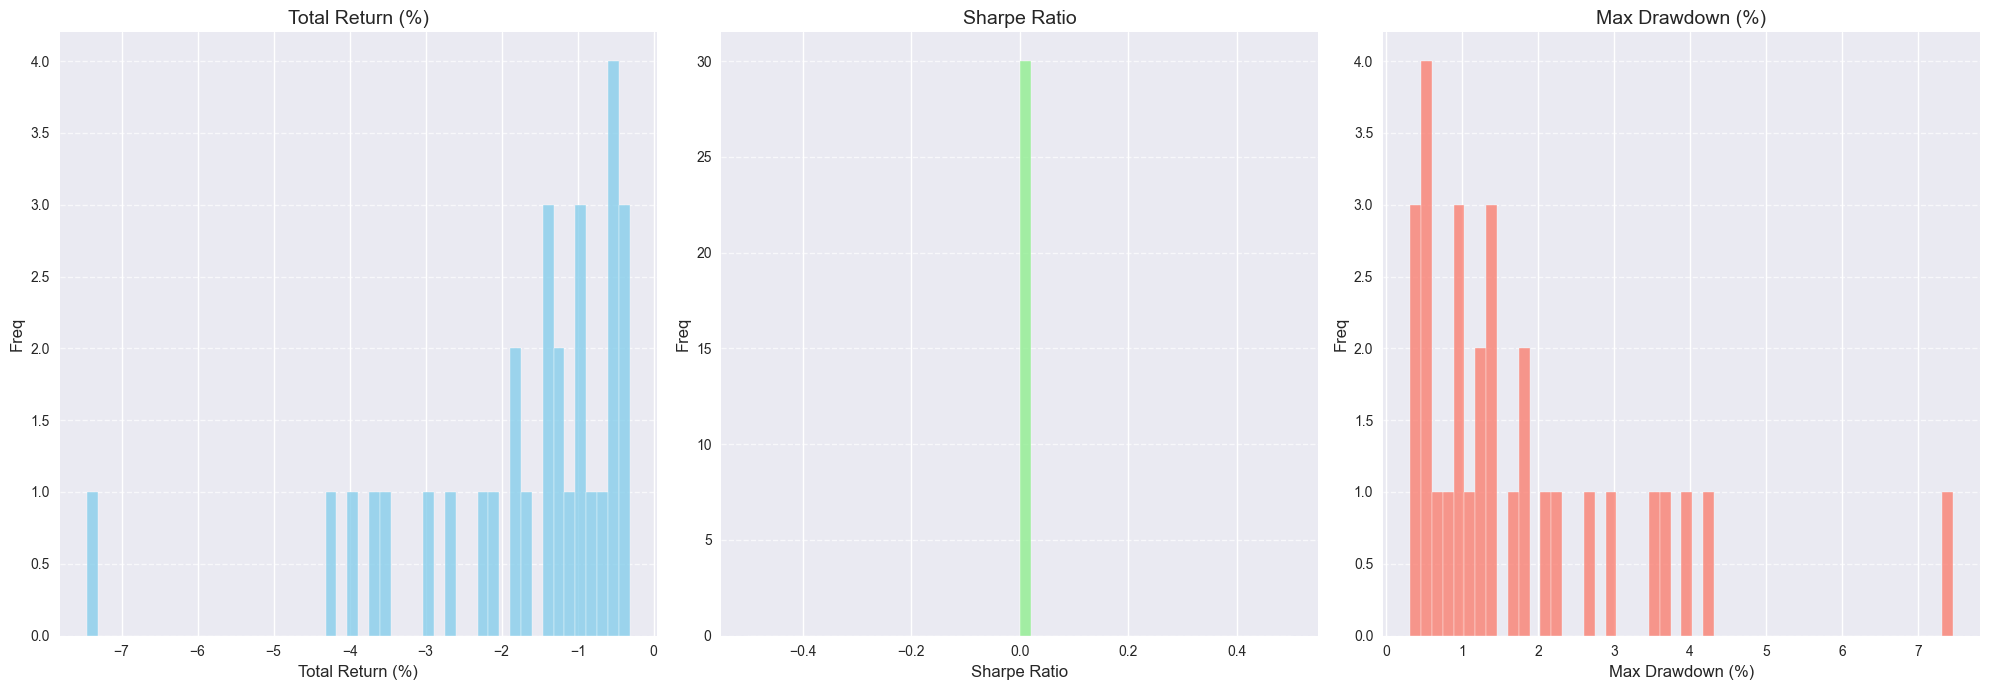


 Optimization have been ended


In [29]:
import backtrader as bt
import pandas as pd
import numpy as np
import random
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

def run_backtest_with_params(params, data_df):
    cerebro = bt.Cerebro()
    
    cerebro.addstrategy(LongShortStrategy, **params)

    df_sorted = data_df.sort_values(by=['datetime', 'ticker']).copy()
    
    min_required_rows_for_indicators = max(LongShortStrategy.params.period, LongShortStrategy.params.atr_period, 2)
    
    loaded_any_data = False
    for ticker_symbol in df_sorted['ticker'].unique():
        ticker_data_df = df_sorted[df_sorted['ticker'] == ticker_symbol].copy()
        
        if 'datetime' in ticker_data_df.columns:
            ticker_data_df.set_index('datetime', inplace=True)
        
        if not isinstance(ticker_data_df.index, pd.DatetimeIndex):
            continue

        if ticker_data_df.empty:
            continue

        ticker_data_df.drop(columns=['ticker'], inplace=True, errors='ignore')

        if ticker_data_df.index.has_duplicates:
            ticker_data_df = ticker_data_df[~ticker_data_df.index.duplicated(keep='first')]

        required_cols = ['open', 'high', 'low', 'close', 'volume', 'volume_imbalance', 'log_return', 'corr_spy']
        missing_cols  = [col for col in required_cols if col not in ticker_data_df.columns]
        if missing_cols:
            continue
        
        if ticker_data_df[required_cols].isnull().any().any():
            continue

        if len(ticker_data_df) < min_required_rows_for_indicators:
            continue

        data = CustomPandasData(
            dataname=ticker_data_df,
            datetime=None,
            open='open',
            high='high',
            low='low',
            close='close',
            volume='volume',
            timeframe=bt.TimeFrame.Minutes,
            compression=1
        )
        cerebro.adddata(data, name=ticker_symbol)
        loaded_any_data = True

    if not loaded_any_data:
        return {
            'final_value': 100000.0,
            'total_return': -100.0,
            'sharpe_ratio': -10.0,
            'max_drawdown': 100.0,
            'num_trades': 0,
            **params
        }
    
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=params.get('stake', 10))
    cerebro.broker.setcommission(commission=0.001)

    # --- Add analyzers ---
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio', riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade_analyzer')

    try:
        strategies = cerebro.run()
        strategy = strategies[0]

        final_value = cerebro.broker.getvalue()
        initial_value = cerebro.broker.startingcash
        total_return = (final_value - initial_value) / initial_value * 100 if initial_value else 0

        sharpe_ratio = strategy.analyzers.sharpe_ratio.get_analysis().get('sharperatio', 0.0)
        max_drawdown = strategy.analyzers.drawdown.get_analysis().get('max', {}).get('drawdown', 100.0)
        
        trade_analysis = strategy.analyzers.trade_analyzer.get_analysis()
        num_trades = trade_analysis.total.closed if hasattr(trade_analysis.total, 'closed') else 0

        return {
            'final_value': final_value,
            'total_return': total_return,
            'sharpe_ratio': sharpe_ratio if sharpe_ratio is not None else 0.0,
            'max_drawdown': max_drawdown,
            'num_trades': num_trades,
            **params
        }

    except Exception as e:
        return {
            'final_value': 100000.0,
            'total_return': -100.0,
            'sharpe_ratio': -10.0,
            'max_drawdown': 100.0,
            'num_trades': 0,
            **params
        }

# --- diapazone for indics ---
param_ranges = {
    'period': {'min': 10, 'max': 40, 'step': 5},
    'buy_threshold_volume_imbalance': {'min': 50000, 'max': 200000, 'step': 25000},
    'sell_threshold_volume_imbalance': {'min': -200000, 'max': -50000, 'step': 25000},
    'correlation_threshold_buy': {'min': 0.3, 'max': 0.8, 'step': 0.1},
    'correlation_threshold_sell': {'min': -0.8, 'max': -0.3, 'step': 0.1},
    'stake': {'min': 5, 'max': 20, 'step': 5},
}

# fixed values
fixed_params = {
    'printlog': False,
    'exit_on_reverse_signal': True,
    'atr_period': 14,
    'atr_multiplier': 2.0,
}

# --- Monte Carlo ---
num_monte_carlo_runs = 30
top_n_results = 5

optimization_results = []

print(f"Launching Monte Carlo ({num_monte_carlo_runs} iterations)...")

# --- Main cicle for Monte Carlo ---
for _ in tqdm(range(num_monte_carlo_runs), desc="Monte Carlo Optimization"):
    current_params = fixed_params.copy()
    for param_name, p_range in param_ranges.items():
        if isinstance(p_range['step'], float):
            current_params[param_name] = round(random.uniform(p_range['min'], p_range['max']), len(str(p_range['step']).split('.')[-1]))
        else:
            current_params[param_name] = random.randrange(p_range['min'], p_range['max'] + p_range['step'], p_range['step'])
    
    result = run_backtest_with_params(current_params, df_long_final)
    optimization_results.append(result)

results_df = pd.DataFrame(optimization_results)

# --- Analyze of result ---
print("\n--- Results ---")

filtered_results_df = results_df[results_df['num_trades'] > 0].copy()

if not filtered_results_df.empty:
    top_runs = filtered_results_df.nlargest(top_n_results, 'final_value')

    print(f"\nTop {top_n_results} combination by Sharpe Ratio:")
    cols_to_display = ['final_value'] + list(param_ranges.keys()) + ['total_return', 'sharpe_ratio', 'max_drawdown', 'num_trades']
    print(top_runs[cols_to_display].to_string())

    best_run = top_runs.iloc[0]
    print("\n Top 1 by Sharpe Ratio:")
    print(best_run[cols_to_display].to_string())
else:
    print("\n Error.")

# --- All together ---
plt.style.use('seaborn-v0_8-darkgrid')

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

axes[0].hist(results_df['total_return'], bins=50, color='skyblue', edgecolor='white', alpha=0.8)
axes[0].set_title('Total Return (%)', fontsize=14)
axes[0].set_xlabel('Total Return (%)', fontsize=12)
axes[0].set_ylabel('Freq', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

axes[1].hist(results_df['sharpe_ratio'], bins=50, color='lightgreen', edgecolor='white', alpha=0.8)
axes[1].set_title('Sharpe Ratio', fontsize=14)
axes[1].set_xlabel('Sharpe Ratio', fontsize=12)
axes[1].set_ylabel('Freq', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

axes[2].hist(results_df['max_drawdown'], bins=50, color='salmon', edgecolor='white', alpha=0.8)
axes[2].set_title('Max Drawdown (%)', fontsize=14)
axes[2].set_xlabel('Max Drawdown (%)', fontsize=12)
axes[2].set_ylabel('Freq', fontsize=12)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("\n Optimization have been ended")